# Timeseries classification from scratch

**Author:** [hfawaz](https://github.com/hfawaz/), [Vijay Yalamanchili](https://github.com/vijaykrishnay/)<br>
**Date created:** 2020/07/21<br>
**Last modified:** 2020/12/15<br>
**Description:** Training a timeseries classifier from scratch on the FordA dataset from the UCR/UEA archive.

## Introduction

This example shows how to do timeseries classification from scratch, starting from raw
CSV timeseries files on disk. We demonstrate the workflow on the FordA dataset from the
[UCR/UEA archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/).

## Setup

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Load the data: the FordA dataset

### Dataset description

The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).

### Read the TSV data

We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing. The simplicity of this dataset
allows us to demonstrate effectively how to use ConvNets for timeseries classification.
In this file, the first column corresponds to the label.

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [3]:
x_train

array([[-0.79717168, -0.66439208, -0.37301463, ..., -0.66439208,
        -1.0737958 , -1.5643427 ],
       [ 0.80485472,  0.63462859,  0.37347448, ..., -0.71488505,
        -0.56044294, -0.31908642],
       [ 0.7279851 ,  0.11128392, -0.49912439, ...,  0.39446303,
         0.33940042,  0.25539062],
       ...,
       [-0.57005428, -0.33316523, -0.29351853, ..., -1.3937145 ,
        -0.94273327, -0.27072168],
       [ 2.0067321 ,  2.0791499 ,  2.0220362 , ..., -0.43214504,
        -0.44123126, -0.28070891],
       [-0.12524091, -0.32536268, -0.48823697, ...,  0.55576053,
         0.57445102,  0.57311598]])

## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

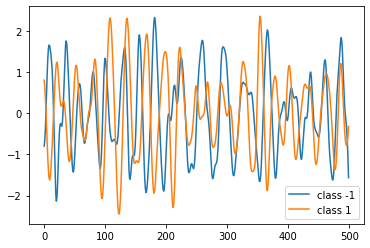

In [4]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Standardize the data

Our timeseries are already in a single length (176). However, their values are
usually in various ranges. This is not ideal for a neural network;
in general we should seek to make the input values normalized.
For this specific dataset, the data is already z-normalized: each timeseries sample
has a mean equal to zero and a standard deviation equal to one. This type of
normalization is very common for timeseries classification problems, see
[Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

Note that the timeseries data used here are univariate, meaning we only have one channel
per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel
using a simple reshaping via numpy.
This will allow us to construct a model that is easily applicable to multivariate time
series.

In [5]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [6]:
num_classes = len(np.unique(y_train))

Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [7]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [8]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build a model

We build a Fully Convolutional Neural Network originally proposed in
[this paper](https://arxiv.org/abs/1611.06455).
The implementation is based on the TF 2 version provided
[here](https://github.com/hfawaz/dl-4-tsc/).
The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found
via random search using [KerasTuner](https://github.com/keras-team/keras-tuner).

In [9]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    lstm1 = keras.layers.LSTM(12, return_sequences=True)(input_layer)
    lstm1 = keras.layers.BatchNormalization()(lstm1)
    lstm1 = keras.layers.Dropout(0.2)(lstm1)
    
    lstm2 = keras.layers.LSTM(32, return_sequences=False)(lstm1)
    lstm2 = keras.layers.BatchNormalization()(lstm2)
    lstm2 = keras.layers.Dropout(0.2)(lstm2)
    
    dense1 = keras.layers.Dense(4, activation="relu")(lstm2)
    
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(dense1)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 500, 12)           672       
_________________________________________________________________
batch_normalization (BatchNo (None, 500, 12)           48        
_________________________________________________________________
dropout (Dropout)            (None, 500, 12)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                5760      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0     

## Train the model

In [10]:
epochs = 300
batch_size = 32
learning_rate = 0.001

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_lstm.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
#     optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/300
90/90 [==============================] - 14s 136ms/step - loss: 0.7614 - sparse_categorical_accuracy: 0.4878 - val_loss: 0.6936 - val_sparse_categorical_accuracy: 0.5284
Epoch 2/300
90/90 [==============================] - 11s 126ms/step - loss: 0.7103 - sparse_categorical_accuracy: 0.5279 - val_loss: 0.6966 - val_sparse_categorical_accuracy: 0.5173
Epoch 3/300
90/90 [==============================] - 11s 126ms/step - loss: 0.7189 - sparse_categorical_accuracy: 0.5231 - val_loss: 0.6911 - val_sparse_categorical_accuracy: 0.5270
Epoch 4/300
90/90 [==============================] - 11s 127ms/step - loss: 0.7148 - sparse_categorical_accuracy: 0.5009 - val_loss: 0.6927 - val_sparse_categorical_accuracy: 0.5381
Epoch 5/300
90/90 [==============================] - 12s 129ms/step - loss: 0.7053 - sparse_categorical_accuracy: 0.5036 - val_loss: 0.6952 - val_sparse_categorical_accuracy: 0.5146
Epoch 6/300
90/90 [==============================] - 11s 127ms/step - loss: 0.7026 - spars

Epoch 46/300
90/90 [==============================] - 12s 133ms/step - loss: 0.4504 - sparse_categorical_accuracy: 0.7632 - val_loss: 1.6355 - val_sparse_categorical_accuracy: 0.5270
Epoch 47/300
90/90 [==============================] - 12s 131ms/step - loss: 0.4854 - sparse_categorical_accuracy: 0.7540 - val_loss: 1.2728 - val_sparse_categorical_accuracy: 0.6227
Epoch 48/300
90/90 [==============================] - 12s 132ms/step - loss: 0.4207 - sparse_categorical_accuracy: 0.7972 - val_loss: 0.7491 - val_sparse_categorical_accuracy: 0.7351
Epoch 49/300
90/90 [==============================] - 12s 131ms/step - loss: 0.5128 - sparse_categorical_accuracy: 0.7444 - val_loss: 0.6177 - val_sparse_categorical_accuracy: 0.6879
Epoch 50/300
90/90 [==============================] - 12s 133ms/step - loss: 0.4991 - sparse_categorical_accuracy: 0.7529 - val_loss: 0.5895 - val_sparse_categorical_accuracy: 0.6824
Epoch 51/300
90/90 [==============================] - 12s 132ms/step - loss: 0.4577 -

Epoch 91/300
90/90 [==============================] - 11s 122ms/step - loss: 0.3089 - sparse_categorical_accuracy: 0.8812 - val_loss: 0.3976 - val_sparse_categorical_accuracy: 0.8308
Epoch 92/300
90/90 [==============================] - 11s 123ms/step - loss: 0.3170 - sparse_categorical_accuracy: 0.8705 - val_loss: 0.3890 - val_sparse_categorical_accuracy: 0.8391
Epoch 93/300
90/90 [==============================] - 11s 123ms/step - loss: 0.3107 - sparse_categorical_accuracy: 0.8722 - val_loss: 0.4964 - val_sparse_categorical_accuracy: 0.8280
Epoch 94/300
90/90 [==============================] - 11s 124ms/step - loss: 0.3283 - sparse_categorical_accuracy: 0.8638 - val_loss: 0.2890 - val_sparse_categorical_accuracy: 0.8863
Epoch 95/300
90/90 [==============================] - 11s 126ms/step - loss: 0.2968 - sparse_categorical_accuracy: 0.8742 - val_loss: 0.2604 - val_sparse_categorical_accuracy: 0.8946
Epoch 96/300
90/90 [==============================] - 11s 126ms/step - loss: 0.2881 -

90/90 [==============================] - 11s 121ms/step - loss: 0.2626 - sparse_categorical_accuracy: 0.8934 - val_loss: 0.2359 - val_sparse_categorical_accuracy: 0.8960
Epoch 136/300
90/90 [==============================] - 11s 119ms/step - loss: 0.2410 - sparse_categorical_accuracy: 0.9081 - val_loss: 0.5042 - val_sparse_categorical_accuracy: 0.8072
Epoch 137/300
90/90 [==============================] - 11s 119ms/step - loss: 0.2475 - sparse_categorical_accuracy: 0.9047 - val_loss: 0.2484 - val_sparse_categorical_accuracy: 0.8988
Epoch 138/300
90/90 [==============================] - 11s 119ms/step - loss: 0.2391 - sparse_categorical_accuracy: 0.9068 - val_loss: 0.2194 - val_sparse_categorical_accuracy: 0.8960
Epoch 139/300
90/90 [==============================] - 11s 120ms/step - loss: 0.2416 - sparse_categorical_accuracy: 0.9099 - val_loss: 0.2350 - val_sparse_categorical_accuracy: 0.9015
Epoch 140/300
90/90 [==============================] - 11s 120ms/step - loss: 0.2337 - sparse_

90/90 [==============================] - 11s 123ms/step - loss: 0.2192 - sparse_categorical_accuracy: 0.9071 - val_loss: 0.4343 - val_sparse_categorical_accuracy: 0.8280
Epoch 180/300
90/90 [==============================] - 11s 124ms/step - loss: 0.2477 - sparse_categorical_accuracy: 0.9036 - val_loss: 0.2620 - val_sparse_categorical_accuracy: 0.9001
Epoch 181/300
90/90 [==============================] - 11s 121ms/step - loss: 0.2178 - sparse_categorical_accuracy: 0.9139 - val_loss: 0.2373 - val_sparse_categorical_accuracy: 0.9015
Epoch 182/300
90/90 [==============================] - 11s 119ms/step - loss: 0.2192 - sparse_categorical_accuracy: 0.9076 - val_loss: 0.3191 - val_sparse_categorical_accuracy: 0.8682
Epoch 183/300
90/90 [==============================] - 11s 120ms/step - loss: 0.2273 - sparse_categorical_accuracy: 0.9085 - val_loss: 0.2196 - val_sparse_categorical_accuracy: 0.9182
Epoch 184/300
90/90 [==============================] - 11s 123ms/step - loss: 0.2270 - sparse_

## Evaluate model on test data

In [12]:
model = keras.models.load_model("best_model_lstm.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 2s 33ms/step - loss: 0.2042 - sparse_categorical_accuracy: 0.9129
Test accuracy 0.9128788113594055
Test loss 0.2042338103055954


## Plot the model's training and validation loss

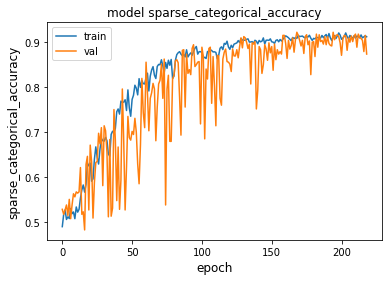

In [13]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

We can see how the training accuracy reaches almost 0.95 after 100 epochs.
However, by observing the validation accuracy we can see how the network still needs
training until it reaches almost 0.97 for both the validation and the training accuracy
after 200 epochs. Beyond the 200th epoch, if we continue on training, the validation
accuracy will start decreasing while the training accuracy will continue on increasing:
the model starts overfitting.